## Given edit and corresponding logit bump, examine the differences 
(run from root)

In [2]:
# General imports
import torch
import numpy as np
import os, sys
import json

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
import pandas as pd
from collections import Counter
from datetime import datetime
import math

In [4]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir, load_image
from utils.df_utils import load_and_preprocess_csv
from utils.visualizations import plot, make_grid, show_image_rows, histogram, boxplot

In [5]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

n_select = 100

edit_trial_dir_template = 'saved/edit_eac/trials/CINIC10_ImageNet-VGG_16/{}_{}/0214_112633'
logit_bump_dir_template = 'saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/{}_{}' 


In [6]:
# Load pre edit logits
pre_edit_logits_path = 'metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth'
pre_edit_logits = torch.load(pre_edit_logits_path)
pre_edit_predictions = torch.argmax(pre_edit_logits, dim=1)
print("Loaded pre-edit logits from {}".format(pre_edit_logits_path))

# Load labels
val_labels_path = 'paths/datasets/cinic-10-imagenet/valid_labels.txt'
val_labels = np.array(read_lists(val_labels_path))
val_labels = val_labels.astype(float)
print("Loaded ground truth labels for validation set from {}".format(val_labels_path))



Loaded pre-edit logits from metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth
Loaded ground truth labels for validation set from paths/datasets/cinic-10-imagenet/valid_labels.txt


### Calculate IOU and spearman correlation between predictions for edit and logit bumping

In [7]:
def get_IOU(logits_a, 
            logits_b, 
            target_class_idx, 
            modes=['binary']):
    
    IOUs = []
    
    if torch.is_tensor(logits_a):
        logits_a = logits_a.cpu().numpy()
    if torch.is_tensor(logits_b):
        logits_b = logits_b.cpu().numpy()
    
    predictions_a = np.argmax(logits_a, axis=1)
    predictions_b = np.argmax(logits_b, axis=1)
    

    
    for mode in modes:
        try:
            if mode == 'binary':
                # Binarize predictions based on target class
                binary_predictions_a = np.where(
                    predictions_a == target_class_idx,
                    1, 0)
                binary_predictions_b = np.where(
                    predictions_b == target_class_idx,
                    1, 0)
                
                IOU = metrics.jaccard_score(
                    y_true=binary_predictions_a,
                    y_pred=binary_predictions_b,
                    average=mode)
            else:
                IOU = metrics.jaccard_score(
                    y_true=predictions_a,
                    y_pred=predictions_b,
                    average=mode)
            IOUs.append(IOU)
        except Exception as e:
            print(e)
            continue
    return IOUs
    
def get_ranking(logits, target_class_idx):
    if not torch.is_tensor(logits):
        logits = torch.from_numpy(logits)
    
    softmax = torch.softmax(logits, dim=1)
    target_softmax = softmax[:, target_class_idx]
    ranking = target_softmax.argsort().argsort()
    
    return ranking.cpu().numpy()

def get_spearman(logits_a, logits_b, target_class_idx):
    ranking_a = get_ranking(
        logits=logits_a,
        target_class_idx=target_class_idx)
    ranking_b = get_ranking(
        logits=logits_b,
        target_class_idx=target_class_idx)
    
    if torch.is_tensor(ranking_a):
        ranking_a = ranking_a.cpu().numpy()
    if torch.is_tensor(ranking_b):
        ranking_b = ranking_b.cpu().numpy()
    spearman = stats.spearmanr(
        a=ranking_a,
        b=ranking_b)
    
    return spearman

### Function to add spearman and IOU to the dataframe

In [8]:
def add_IOU_Spearman_to_df(df,
                           edit_trial_paths,
                           logit_bump_trial_paths,
                           target_class_idx,
                           id1=None,
                           id2=None,
                           IOU_modes=['binary', 'micro', 'weighted']):
    stored_data = []
    column_names = ['{} IOU'.format(mode) for mode in IOU_modes] + ['Spearman', 'Spearman pvalue']
    
    # Iterate through all trials
    for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(tqdm(zip(edit_trial_paths, logit_bump_trial_paths))):
        # if trial_idx == 10:
        #     break

        # Extract image_id
        image_id = edit_trial_path.split('results/')[-1]
        assert image_id in logit_bump_trial_path

        assert len(image_id) > 1
        try: 
            assert image_id in df['ID'].iloc[trial_idx], \
                "ID {} not found in edit trial data frame {}".format(image_id,  df['ID'].iloc[trial_idx])
        except:
            assert image_id in df['{} ID'.format(id1)].iloc[trial_idx], \
                "ID {} not found in edit trial data frame {}".format(image_id,  df['{} ID'.format(id1)].iloc[trial_idx])
        # sort_metric_value = edit_trial_df[sort_metric].iloc[trial_idx]

        # Create directory for this trial
        # trial_dir = os.path.join(trial_root_dir, image_id)

        # Load edited and logit bump logits
        edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
        logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')
        edit_trial_logits = torch.load(edit_trial_logits_path)
        logit_bump_logits = torch.load(logit_bump_logits_path)

        # Calculate IOUs
        IOUs = get_IOU(
            logits_a=edit_trial_logits,
            logits_b=logit_bump_logits,
            target_class_idx=target_class_idx,
            modes=IOU_modes)
        # Calculate Spearman Correlation
        spearman = get_spearman(
            logits_a=edit_trial_logits,
            logits_b=logit_bump_logits,
            target_class_idx=target_class_idx)
        stored_data.append(IOUs + [spearman.correlation, spearman.pvalue])

    # Add columns to data frame
    # Store IOUs and Spearman into data frame
    stored_data = np.array(stored_data)
    assert len(column_names) == stored_data.shape[1]
    for idx, column_name in enumerate(column_names):
        df[column_name] = stored_data[:, idx]
        
    return df

### Calculate metrics for all 10 classes and write to a .pth and .txt file

In [9]:
def combine_df(df1, df2, id1, id2):
    '''
    Create dataframe that combines the columns of df1 and df2
    '''
    
    assert id1 != id2
    df1_rename = {}
    df2_rename = {}
    for col in df1.columns:
        df1_rename[col] = "{} {}".format(id1, col)
    for col in df2.columns:
        df2_rename[col] = "{} {}".format(id2, col)
    df1 = df1.rename(columns=df1_rename)
    df2 = df2.rename(columns=df2_rename)
    
    combined_df = pd.concat([df1, df2], axis=1)
    return combined_df
    
def get_global_metrics(combined_df,
                       class_name,
                       id1,
                       id2,
                       metric_name):
    metric_data = {}
    # Obtain pre edit value
    pre_val = combined_df['{} {} {}'.format(id1, 'Pre', metric_name)].mean()
    assert pre_val == combined_df['{} {} {}'.format(id2, 'Pre', metric_name)].mean(), \
        "Inconsistent values for pre edit metric {} in {} class ({} and {})".format(
        metric_name, class_name, pre_val, combined_df['{} {} {}'.format(id2, 'Pre', metric_name)].mean())
    metric_data['pre'] = pre_val

    # Obtain post edit from df1 value
    col1 = combined_df['{} {} {}'.format(id1, 'Post', metric_name)]
    df1_val = col1.mean()
    metric_data[id1] = df1_val

    # Obtain post edit from df2 value
    col2 = combined_df['{} {} {}'.format(id2, 'Post', metric_name)]
    df2_val = col2.mean()
    metric_data[id2] = df2_val

    # Obtain average difference 
    mean_diff = np.mean(col1.to_numpy() - col2.to_numpy())
    metric_data['mean diff'] = mean_diff
    
    return metric_data

def get_granular_metrics(sorted_df,
                        n_top, 
                        metric_name):
    if metric_name == 'Spearman':
        metric_data = {}
        mean = sorted_df[metric_name].mean()
        std =  sorted_df[metric_name].std()
        
        metric_data[metric_name] = (mean, std)
        
        # Get p value too
        p_mean = sorted_df['{} pvalue'.format(metric_name)].mean()
        p_std = sorted_df['{} pvalue'.format(metric_name)].std()
        n_significant = len(sorted_df[sorted_df['{} pvalue'.format(metric_name)] < 0.05])
        metric_data['{} pvalue'.format(metric_name)] = {
            'mean': p_mean,
            'std': p_std,
            'n_significant': n_significant
        }
    else:
        metric_data = {}
        metric_data['n_top'] = n_top

        mean_top = sorted_df[metric_name][:n_top].mean()
        std_top = sorted_df[metric_name][:n_top].std()
        metric_data['{} {}'.format('top', metric_name)] = (mean_top, std_top)

        mean_bottom = sorted_df[metric_name][-n_top:].mean()
        std_bottom = sorted_df[metric_name][-n_top:].std()

        metric_data['{} {}'.format('bottom', metric_name)] = (mean_bottom, std_bottom)
    
    return metric_data

[0307_105305] Saving metrics for airplane class...


158it [00:20,  7.72it/s]


n improved: 1
Looking at 3 rows for granular metrics


<Figure size 640x480 with 0 Axes>

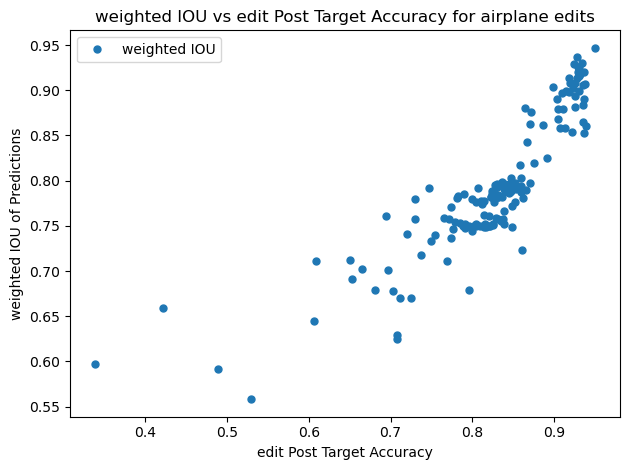

<Figure size 640x480 with 0 Axes>

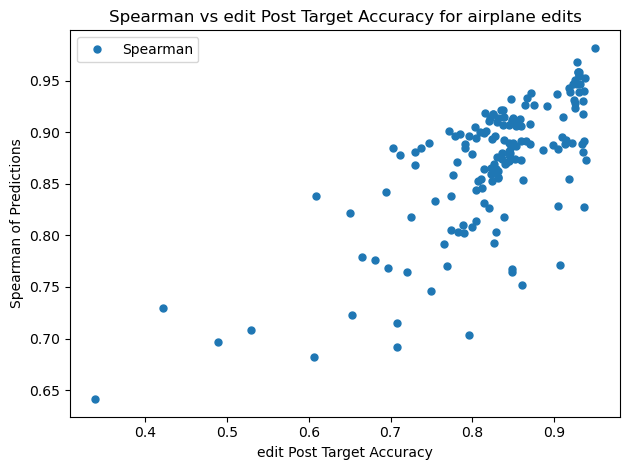

{'Target Accuracy': {'pre': 0.9470000000000001, 'edit': 0.8247721518987341, 'logit bump': 0.8242531645569618, 'mean diff': 0.0005189873417721516}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6110379746835443, 'logit bump': 0.6387405063291139, 'mean diff': -0.027702531645569642}, 'n_samples': 158, 'n_improvements': 1, 'weighted IOU': {'n_top': 3, 'top weighted IOU': (0.904787371502441, 0.043121720707811506), 'bottom weighted IOU': (0.6162755369508903, 0.037560169896195525)}, 'Spearman': {'Spearman': (0.8697054713004073, 0.06444242838971506), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 158}}}
[0307_105326] Saving metrics for automobile class...


122it [00:14,  8.61it/s]


n improved: 0
Looking at 14 rows for granular metrics


<Figure size 640x480 with 0 Axes>

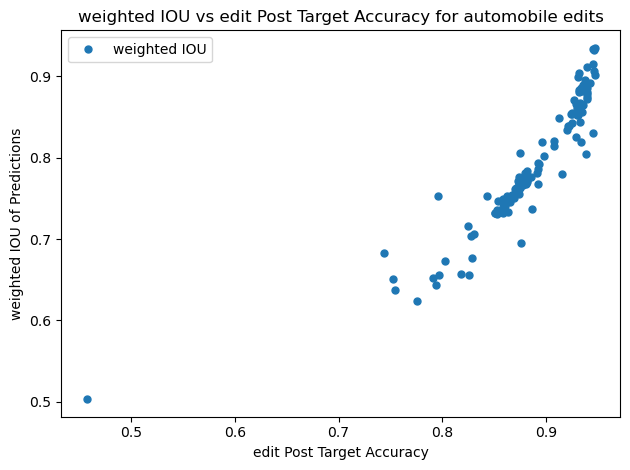

<Figure size 640x480 with 0 Axes>

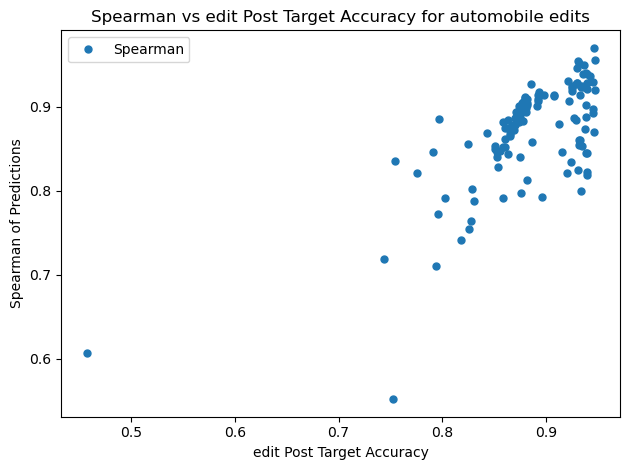

{'Target Accuracy': {'pre': 0.9499999999999998, 'edit': 0.8846147540983605, 'logit bump': 0.8822868852459017, 'mean diff': 0.0023278688524590147}, 'Mean Accuracy': {'pre': 0.6869999999999999, 'edit': 0.6389672131147541, 'logit bump': 0.6634672131147541, 'mean diff': -0.024500000000000022}, 'n_samples': 122, 'n_improvements': 0, 'weighted IOU': {'n_top': 14, 'top weighted IOU': (0.8966307562494145, 0.028971691389790465), 'bottom weighted IOU': (0.6576221953014452, 0.0561936165721918)}, 'Spearman': {'Spearman': (0.8712470169974914, 0.06314464638541475), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 122}}}
[0307_105341] Saving metrics for bird class...


146it [00:17,  8.50it/s]


n improved: 0
Looking at 2 rows for granular metrics


<Figure size 640x480 with 0 Axes>

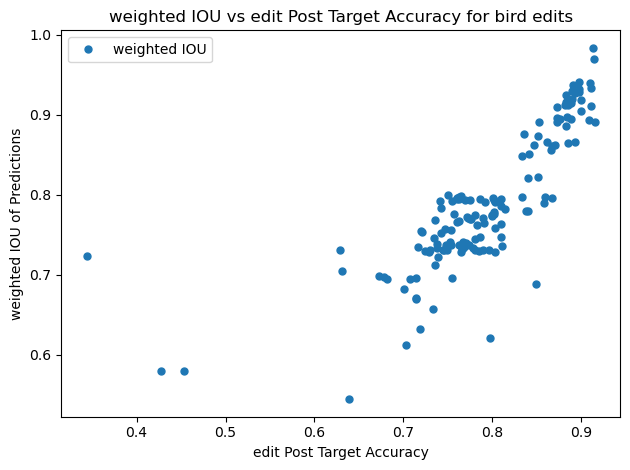

<Figure size 640x480 with 0 Axes>

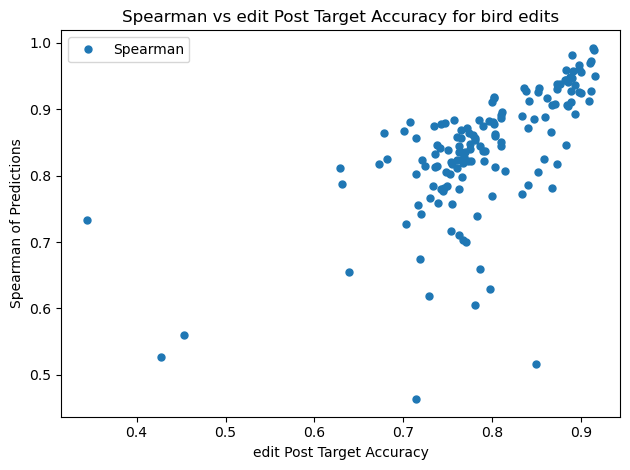

{'Target Accuracy': {'pre': 0.923, 'edit': 0.7906369863013698, 'logit bump': 0.7967191780821917, 'mean diff': -0.006082191780821918}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6071712328767123, 'logit bump': 0.6398082191780823, 'mean diff': -0.03263698630136989}, 'n_samples': 146, 'n_improvements': 0, 'weighted IOU': {'n_top': 2, 'top weighted IOU': (0.930050567567504, 0.05609206127454721), 'bottom weighted IOU': (0.6510608889115181, 0.10196518106097743)}, 'Spearman': {'Spearman': (0.8390201621178113, 0.09458145778840131), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 146}}}
[0307_105359] Saving metrics for cat class...


128it [00:15,  8.30it/s]


n improved: 0
Looking at 10 rows for granular metrics


<Figure size 640x480 with 0 Axes>

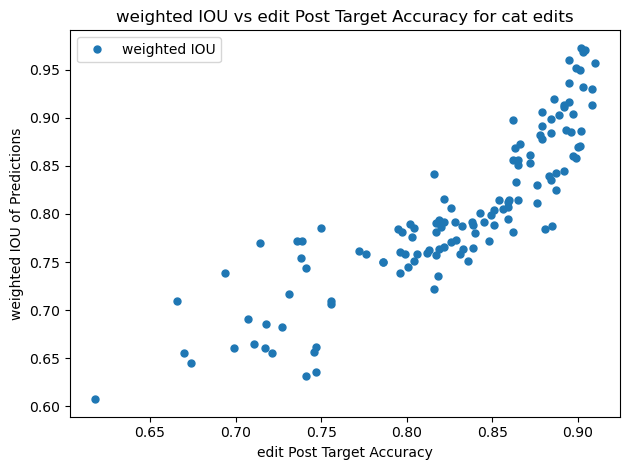

<Figure size 640x480 with 0 Axes>

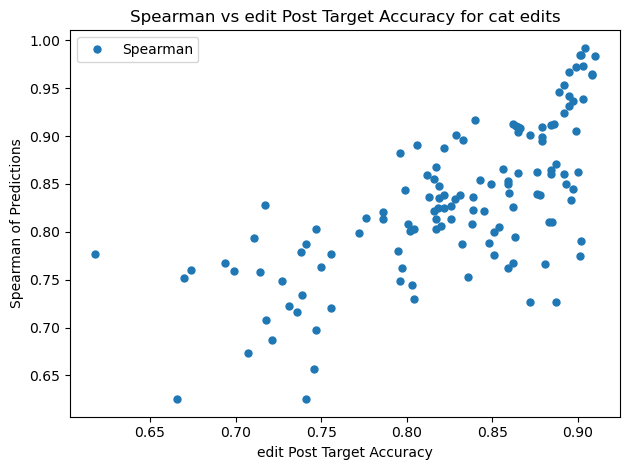

{'Target Accuracy': {'pre': 0.9109999999999997, 'edit': 0.8272421875, 'logit bump': 0.832234375, 'mean diff': -0.004992187500000003}, 'Mean Accuracy': {'pre': 0.6869999999999999, 'edit': 0.63559375, 'logit bump': 0.6657421875, 'mean diff': -0.03014843750000002}, 'n_samples': 128, 'n_improvements': 0, 'weighted IOU': {'n_top': 10, 'top weighted IOU': (0.9351270286384002, 0.035895996824396065), 'bottom weighted IOU': (0.6801094846744605, 0.047760259190546085)}, 'Spearman': {'Spearman': (0.8309714788350878, 0.07774504981172536), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 128}}}
[0307_105415] Saving metrics for deer class...


72it [00:10,  6.79it/s]


n improved: 2
Looking at 6 rows for granular metrics


<Figure size 640x480 with 0 Axes>

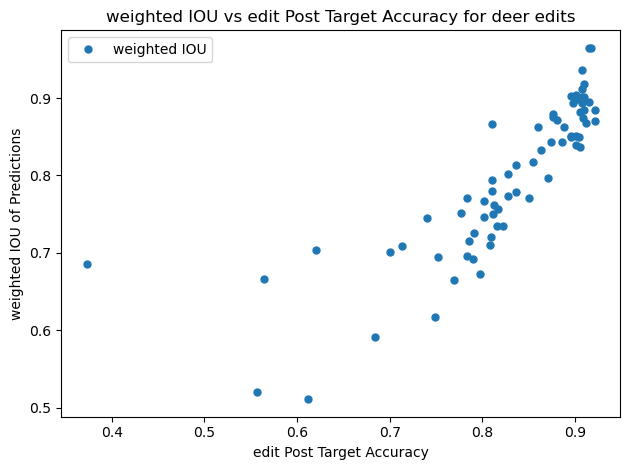

<Figure size 640x480 with 0 Axes>

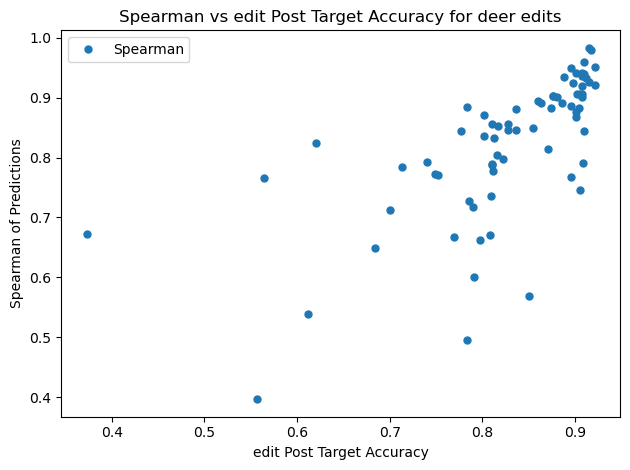

{'Target Accuracy': {'pre': 0.9200000000000002, 'edit': 0.8271111111111111, 'logit bump': 0.8332638888888888, 'mean diff': -0.006152777777777769}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6279444444444445, 'logit bump': 0.6562916666666667, 'mean diff': -0.028347222222222246}, 'n_samples': 72, 'n_improvements': 2, 'weighted IOU': {'n_top': 6, 'top weighted IOU': (0.907891138288436, 0.045124312275757084), 'bottom weighted IOU': (0.6127233234849242, 0.08469222927459959)}, 'Spearman': {'Spearman': (0.8228362492547949, 0.11806459835647089), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 72}}}
[0307_105426] Saving metrics for dog class...


55it [00:06,  8.21it/s]


n improved: 1
Looking at 28 rows for granular metrics


<Figure size 640x480 with 0 Axes>

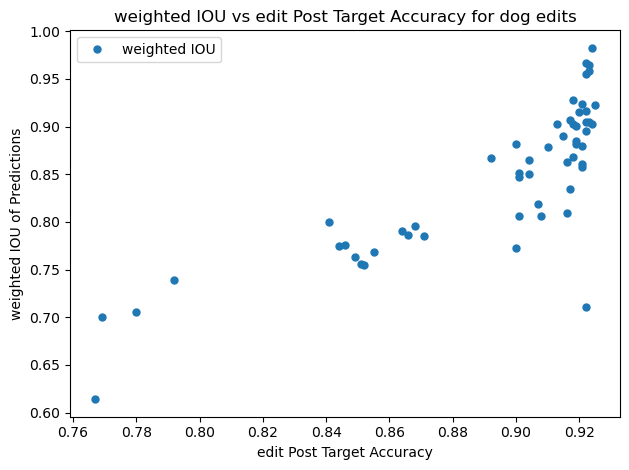

<Figure size 640x480 with 0 Axes>

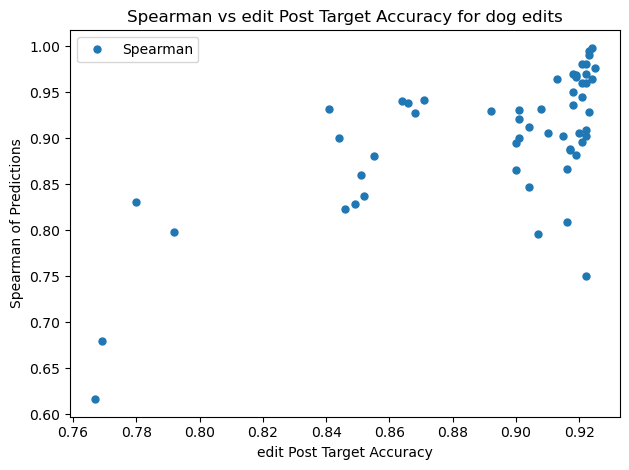

{'Target Accuracy': {'pre': 0.9249999999999996, 'edit': 0.8931999999999999, 'logit bump': 0.896872727272727, 'mean diff': -0.003672727272727274}, 'Mean Accuracy': {'pre': 0.6869999999999998, 'edit': 0.6677090909090908, 'logit bump': 0.6835818181818182, 'mean diff': -0.01587272727272724}, 'n_samples': 55, 'n_improvements': 1, 'weighted IOU': {'n_top': 28, 'top weighted IOU': (0.8960548014033615, 0.054173856471252634), 'bottom weighted IOU': (0.7981201418538909, 0.06491220307937261)}, 'Spearman': {'Spearman': (0.9011262838196954, 0.0750695371467437), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 55}}}
[0307_105434] Saving metrics for frog class...


132it [00:16,  8.04it/s]


n improved: 0
Looking at 4 rows for granular metrics


<Figure size 640x480 with 0 Axes>

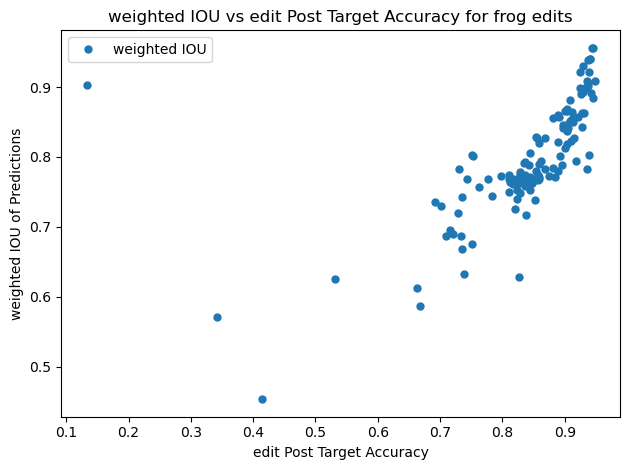

<Figure size 640x480 with 0 Axes>

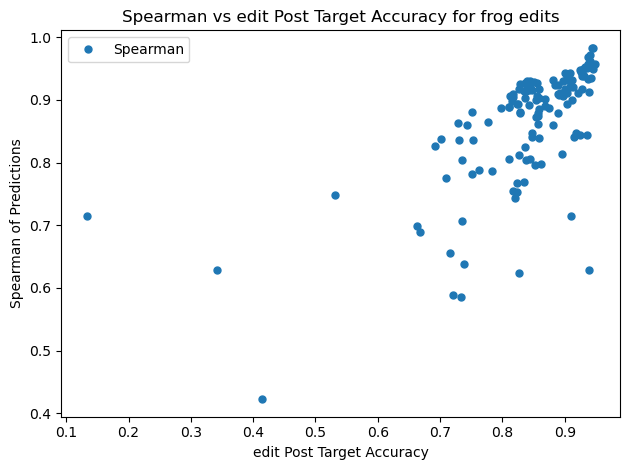

{'Target Accuracy': {'pre': 0.9530000000000002, 'edit': 0.8383787878787878, 'logit bump': 0.8411666666666667, 'mean diff': -0.0027878787878787884}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6203484848484848, 'logit bump': 0.6470757575757576, 'mean diff': -0.026727272727272745}, 'n_samples': 132, 'n_improvements': 0, 'weighted IOU': {'n_top': 4, 'top weighted IOU': (0.9263005965203224, 0.035324741437773796), 'bottom weighted IOU': (0.6378187681947097, 0.19036717399725966)}, 'Spearman': {'Spearman': (0.8635110296140869, 0.09497610440518517), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 132}}}
[0307_105451] Saving metrics for horse class...


83it [00:09,  8.44it/s]


n improved: 4
Looking at 26 rows for granular metrics


<Figure size 640x480 with 0 Axes>

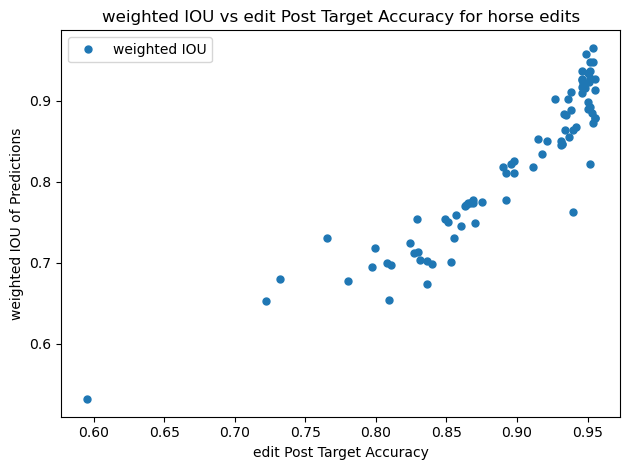

<Figure size 640x480 with 0 Axes>

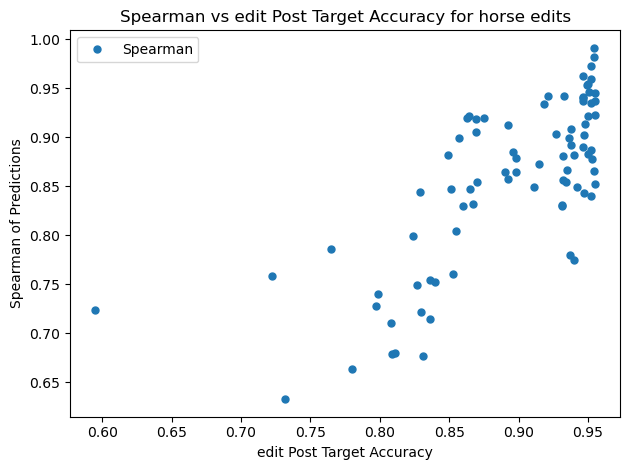

{'Target Accuracy': {'pre': 0.9549999999999998, 'edit': 0.8929156626506023, 'logit bump': 0.8976626506024097, 'mean diff': -0.004746987951807226}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6473855421686746, 'logit bump': 0.6723493975903615, 'mean diff': -0.02496385542168673}, 'n_samples': 83, 'n_improvements': 4, 'weighted IOU': {'n_top': 26, 'top weighted IOU': (0.9140746366484992, 0.031086926535161645), 'bottom weighted IOU': (0.7076047397211759, 0.048862302157883016)}, 'Spearman': {'Spearman': (0.8555538786245553, 0.08407606432075168), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 83}}}
[0307_105501] Saving metrics for ship class...


67it [00:08,  8.36it/s]


n improved: 0
Looking at 18 rows for granular metrics


<Figure size 640x480 with 0 Axes>

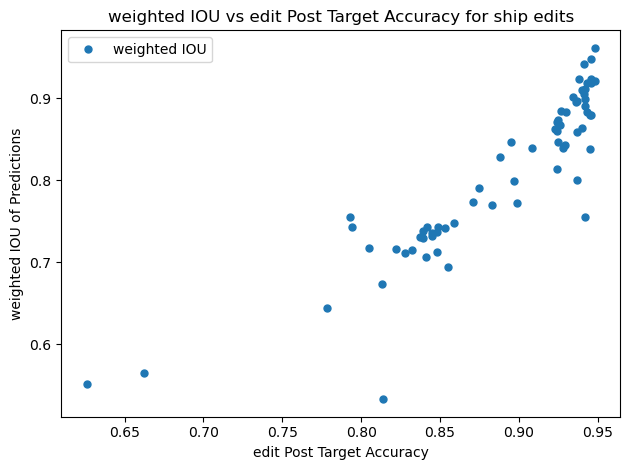

<Figure size 640x480 with 0 Axes>

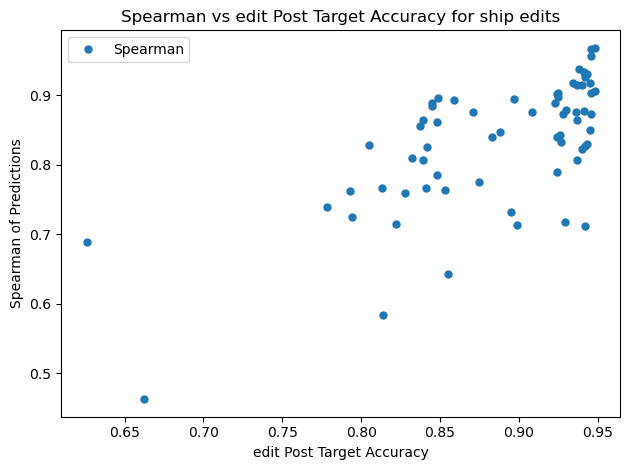

{'Target Accuracy': {'pre': 0.9489999999999998, 'edit': 0.8876567164179104, 'logit bump': 0.8912985074626867, 'mean diff': -0.0036417910447761226}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6474328358208955, 'logit bump': 0.6733432835820896, 'mean diff': -0.025910447761194028}, 'n_samples': 67, 'n_improvements': 0, 'weighted IOU': {'n_top': 18, 'top weighted IOU': (0.8969279428075025, 0.04646819959611644), 'bottom weighted IOU': (0.691173916581928, 0.0701200050300781)}, 'Spearman': {'Spearman': (0.8338702210737491, 0.09258252180806895), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 67}}}
[0307_105510] Saving metrics for truck class...


119it [00:14,  8.34it/s]


n improved: 0
Looking at 25 rows for granular metrics


<Figure size 640x480 with 0 Axes>

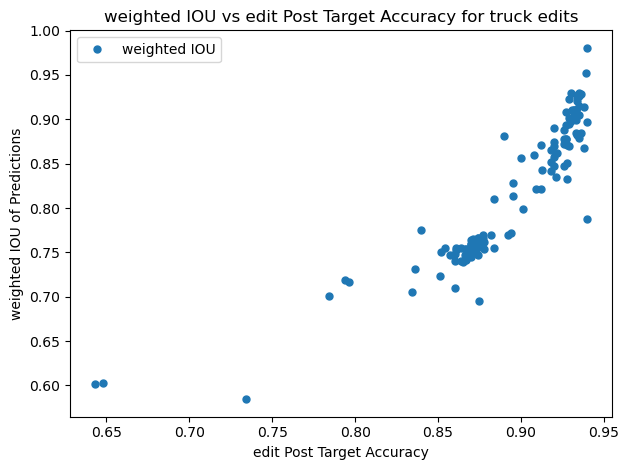

<Figure size 640x480 with 0 Axes>

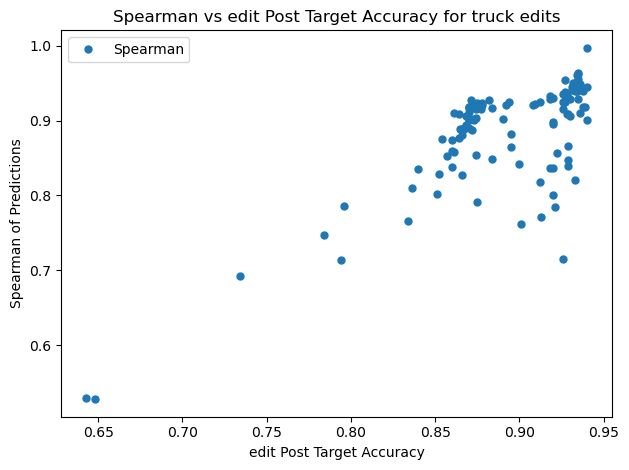

{'Target Accuracy': {'pre': 0.9410000000000004, 'edit': 0.892201680672269, 'logit bump': 0.8848655462184876, 'mean diff': 0.007336134453781515}, 'Mean Accuracy': {'pre': 0.6869999999999998, 'edit': 0.6513949579831935, 'logit bump': 0.6710672268907567, 'mean diff': -0.019672268907563042}, 'n_samples': 119, 'n_improvements': 0, 'weighted IOU': {'n_top': 25, 'top weighted IOU': (0.9061649441975483, 0.034375172272419215), 'bottom weighted IOU': (0.7219806151152781, 0.05070561019339062)}, 'Spearman': {'Spearman': (0.8851011342345972, 0.0743268069313618), 'Spearman pvalue': {'mean': 0.0, 'std': 0.0, 'n_significant': 119}}}
{'airplane': {'Target Accuracy': {'pre': 0.9470000000000001, 'edit': 0.8247721518987341, 'logit bump': 0.8242531645569618, 'mean diff': 0.0005189873417721516}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6110379746835443, 'logit bump': 0.6387405063291139, 'mean diff': -0.027702531645569642}, 'n_samples': 158, 'n_improvements': 1, 'weighted IOU': {'n_top': 3, 'to

In [10]:
def save_metrics(overall_metric_names, 
                 granular_metric_names,
                 granular_sort_metric,
                 granular_criteria,
                 id1, id2):
    
    all_class_metrics = {}
    for class_idx, class_name in enumerate(class_list):
        # if class_idx > 0: 
        #     break
        print("[{}] Saving metrics for {} class...".format(datetime.now().strftime(r'%m%d_%H%M%S'), class_name))
        class_metrics = {}
        # Get paths to post trial paths and results.csv
        edit_trial_dir = edit_trial_dir_template.format(class_name, n_select)
        edit_trial_paths_path = os.path.join(edit_trial_dir, 'trial_paths.txt')
        assert '{}_{}'.format(class_name, n_select) in edit_trial_paths_path
        edit_trial_csv_path = os.path.join(edit_trial_dir, 'results_table.csv')

        logit_bump_dir = logit_bump_dir_template.format(class_name, n_select)
        logit_bump_trial_paths_path = os.path.join(logit_bump_dir, 'trial_paths.txt'.format(class_name, n_select))
        assert '{}_{}'.format(class_name, n_select) in logit_bump_trial_paths_path
        logit_bump_csv_path = os.path.join(logit_bump_dir, 'results_table.csv')

        # Load trial paths
        edit_trial_paths = read_lists(edit_trial_paths_path)
        logit_bump_trial_paths = read_lists(logit_bump_trial_paths_path)
        
        # Assert trial paths have same length
        assert len(edit_trial_paths) == len(logit_bump_trial_paths), \
            "Unequal length paths for edits ({}) and logit bumping ({})".format(len(edit_trial_paths), len(logit_bump_trial_paths))

        # Load CSV from original results
        edit_trial_df = load_and_preprocess_csv(
            csv_path=edit_trial_csv_path,
            drop_duplicates=['ID'],
            round_to=3)
        logit_bump_df = load_and_preprocess_csv(
            csv_path=logit_bump_csv_path,
            drop_duplicates=['ID'],
            round_to=3)

        # Combine the data frames
        combined_df = combine_df(
            df1=edit_trial_df,
            df2=logit_bump_df,
            id1=id1,
            id2=id2)
        
        
        # Sanity check that the rows line up
        assert (combined_df["{} {}".format(id1, "ID")] == combined_df["{} {}".format(id2, "ID")]).all(), \
            " Inconsistent rows between {} and {} DFs".format(id1, id2)
        
        # Add IOU and Spearman values to DF
        combined_df = add_IOU_Spearman_to_df(
            df=combined_df,
            target_class_idx=class_idx,
            id1=id1,
            id2=id2,
            edit_trial_paths=edit_trial_paths,
            logit_bump_trial_paths=logit_bump_trial_paths,
            IOU_modes=['binary', 'micro', 'weighted'])

        # Save combined DF
        df_save_path = os.path.join(logit_bump_dir, 'combined_df_IOU_Spearman.csv')
        combined_df.to_csv(df_save_path)
        
        # Save global metrics
        for metric_name in overall_metric_names:
            metric_data = get_global_metrics(
                combined_df=combined_df,
                class_name=class_name,
                id1=id1,
                id2=id2,
                metric_name=metric_name)

            class_metrics[metric_name] = metric_data
        
       
        # Save granular metrics
        
        # Obtain # of rows depending on granular_criteria
        n_rows_total = len(combined_df)
        sort_metric = '{} Post {}'.format(id1, granular_sort_metric)
        sorted_df = combined_df.sort_values(sort_metric, ascending=False)
        
        # Store n_samples
        n_samples = len(sorted_df)
        class_metrics['n_samples'] = n_samples
        pre_edit_metric = sort_metric.replace('Post', 'Pre')
        pre_edit_value = combined_df[pre_edit_metric].mean()
        n_improvements = len(sorted_df[sorted_df[sort_metric] > pre_edit_value])
        print("n improved: {}".format(n_improvements))
        class_metrics['n_improvements'] = n_improvements

        # Obtain number of rows to look at
        if granular_criteria[0] == 'cutoff #':
            n_top = granular_criteria[1]
        elif granular_criteria[0] == 'cutoff %':
            percent = granular_criteria[1]
            assert type(percent) == float and percent < 1
            n_top = math.floor(n_rows_total * percent)
        elif granular_criteria[0] == 'window':
            metric_drop = granular_criteria[1]

            pre_edit_metric = sort_metric.replace('Post', 'Pre')
            pre_edit_value = combined_df[pre_edit_metric].mean()
            n_top = len(combined_df[combined_df[sort_metric] > pre_edit_value - metric_drop])
            
        print("Looking at {} rows for granular metrics".format(n_top))
        
        for granular_metric in granular_metric_names:
            metric_data = get_granular_metrics(
                sorted_df=sorted_df,
                n_top=n_top, 
                metric_name=granular_metric)
            class_metrics[granular_metric] = metric_data
            
            plot(
                xs=[sorted_df[sort_metric].to_numpy()],
                ys=[sorted_df[granular_metric].to_numpy()],
                labels=[granular_metric],
                marker_size=5,
                title='{} vs {} for {} edits'.format(granular_metric, sort_metric, class_name),
                xlabel=sort_metric,
                ylabel='{} of Predictions'.format(granular_metric),
                line=False,
                show=True)
        print(class_metrics)
        all_class_metrics[class_name] = class_metrics
        # if class_name == 'airplane':
        #     break
        
    return all_class_metrics

all_metrics = save_metrics(
    overall_metric_names=['Target Accuracy', 'Mean Accuracy'],
    granular_metric_names=['weighted IOU', 'Spearman'],
    granular_sort_metric="Target Accuracy",
    granular_criteria=('window', 0.01), # threshold, cutoff #, cutoff %
    id1='edit',
    id2='logit bump') 

print(all_metrics)
torch_save_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_class_results.pth')
json_save_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_class_results.json')

torch.save(all_metrics, torch_save_path)
with open(json_save_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)

### Loop through the corresponding edit bump trials to obtain the combined CSVs, combine into one and obtain reportable metrics

In [11]:
logit_bump_trial_dir_template = 'saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/{}_{}'
combined_csv_path_template = os.path.join(logit_bump_trial_dir_template, 'combined_df_IOU_Spearman.csv')
logit_bump_save_dir = os.path.dirname(logit_bump_trial_dir_template)

# Things to load
all_class_csv_save_path = os.path.join(logit_bump_save_dir, 'all_class_csv.csv')
all_class_results_torch_path = os.path.join(logit_bump_save_dir, 'all_class_results.pth')

# Things to save



In [12]:
# Create combined CSV (probably don't have to run again)
all_class_df = None
for class_name in class_list:
    combined_csv_path = combined_csv_path_template.format(class_name, n_select)
    print("Obtaining csv for {} class from {}".format(class_name, combined_csv_path))
    
    class_df = load_and_preprocess_csv(csv_path=combined_csv_path)
    if all_class_df is None:
        all_class_df = class_df
    else:
        all_class_df = all_class_df.append(class_df, ignore_index=True)

# Save CSV
all_class_df.to_csv(all_class_csv_save_path)

print("Saved CSV for all classes to {}".format(all_class_csv_save_path))

Obtaining csv for airplane class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/airplane_100/combined_df_IOU_Spearman.csv
Obtaining csv for automobile class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/automobile_100/combined_df_IOU_Spearman.csv
Obtaining csv for bird class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/bird_100/combined_df_IOU_Spearman.csv
Obtaining csv for cat class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/cat_100/combined_df_IOU_Spearman.csv
Obtaining csv for deer class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/deer_100/combined_df_IOU_Spearman.csv
Obtaining csv for dog class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/dog_100/combined_df_IOU_Spearman.csv
Obtaining csv for frog c

## Load data to analyze results

In [13]:
# Obtain combined CSV, all_results torch
all_class_csv_save_path = os.path.join(logit_bump_save_dir, 'all_class_csv.csv')

all_class_df = load_and_preprocess_csv(csv_path=all_class_csv_save_path)
all_class_results = torch.load(all_class_results_torch_path)

overall_results = {}

#### Obtain # of example that improved target class accuracy and overall accuracy

In [14]:
n_improve_target_accuracy = len(all_class_df[all_class_df['edit Pre Target Accuracy'] < all_class_df['edit Post Target Accuracy']])
print("{} improved target class accuracy".format(n_improve_target_accuracy))

n_improve_overall_accuracy = len(all_class_df[all_class_df['edit Pre Mean Accuracy'] < all_class_df['edit Post Mean Accuracy']])
print("{} improved overall accuracy".format(n_improve_overall_accuracy))

#
pre_class_dists = all_class_df['edit Pre Class Dist'].to_numpy()
post_class_dists = all_class_df['edit Post Class Dist'].to_numpy()
target_class = all_class_df['edit Post val Prediction'].to_numpy()

pre_target_preds = []
post_target_preds = []
for row_idx, target_class_idx in enumerate(target_class):
    pre_target_preds.append(pre_class_dists[row_idx][target_class_idx])
    post_target_preds.append(post_class_dists[row_idx][target_class_idx])

all_class_df['edit Num Pre Target Predictions'] = pre_target_preds
all_class_df['edit Num Post Target Predictions'] = post_target_preds


n_increased_target_class = len(all_class_df[all_class_df['edit Num Pre Target Predictions'] < all_class_df['edit Num Post Target Predictions']])
print("{} imcreased target predictions".format(n_increased_target_class))    

overall_results['n_improved_target_accuracy'] = n_improve_target_accuracy
overall_results['n_improve_overall_accuracy'] = n_improve_overall_accuracy
overall_results['n_increased_target_class'] = n_increased_target_class


3 improved target class accuracy
32 improved overall accuracy
1081 imcreased target predictions


#### Obtain difference in target and overall accuracy between calibration and edited model

In [15]:
edit_calibrated_diff = all_class_df['logit bump Post Target Accuracy'] - all_class_df['edit Post Target Accuracy']
mean_edit_calibrated_diff = edit_calibrated_diff.mean()
std_edit_calibrated_diff = edit_calibrated_diff.std()

print("On average, calibrated target accuracy differs from edited target accuracy by {} ({})".format(mean_edit_calibrated_diff, std_edit_calibrated_diff)) 
overall_results['diff_target_accuracy'] = (mean_edit_calibrated_diff, std_edit_calibrated_diff)
    

On average, calibrated target accuracy differs from edited target accuracy by 0.0017920517560073934 (0.007542308151530143)


#### Graph IOU vs Post target accuracy for all edits

<Figure size 640x480 with 0 Axes>

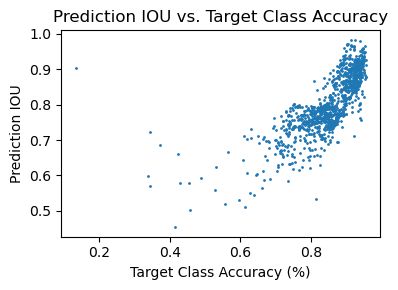

Saved IOU plot to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/IOU_vs_post_target_acc.png
Pearson correlation coefficient: 0.754441504957006 pvalue: 1.0614047552500866e-199
Average IOU: 0.802119457762163 (0.08457992004134086)


In [33]:
iou_plot_save_path = os.path.join(logit_bump_save_dir, 'IOU_vs_post_target_acc.png')

x_col = 'edit Post Target Accuracy'
y_col = 'weighted IOU'
sort_post_target_acc_df = all_class_df.sort_values(x_col)
xs = sort_post_target_acc_df[x_col].to_numpy()
ious = sort_post_target_acc_df[y_col].to_numpy()


plot(
    xs=[xs],
    ys=[ious],
    marker_size=1,
    title='Prediction IOU vs. Target Class Accuracy',
    xlabel='Target Class Accuracy (%)',
    ylabel='Prediction IOU',
    line=False,
    show=True,
    fig_size=(4,3),
    save_path=iou_plot_save_path)
print("Saved IOU plot to {}".format(iou_plot_save_path))
# Calculate the Pearson correlation coefficient
linreg = stats.linregress(x=xs, y=ys)
print("Pearson correlation coefficient: {} pvalue: {}".format(linreg.rvalue, linreg.pvalue))
overall_results['IOU'] = {
    'pearson': linreg.rvalue,
    'pvalue': linreg.pvalue,
    'slope': linreg.slope,
    'yint': linreg.intercept
}

print("Average IOU: {} ({})".format(np.mean(ys), np.std(ys)))

#### Average spearman coefficient

<Figure size 640x480 with 0 Axes>

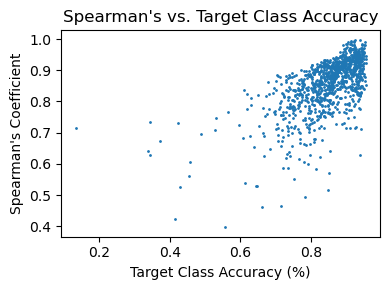

Pearson correlation coefficient: 0.6368266230393922 pvalue: 4.013559786904351e-124
Spearman's: 0.8572678527508635 (0.08589500897844787)
Spearman's % of trials with pval < 0.001: 1.0


In [36]:
# spearmans = all_class_df['Spearman']
spearmans_plot_save_path = os.path.join(logit_bump_save_dir, 'spearman_vs_post_target_acc.png')

x_col = 'edit Post Target Accuracy'
sort_post_target_acc_df = all_class_df.sort_values(x_col)
xs = sort_post_target_acc_df[x_col].to_numpy()
spearmans = sort_post_target_acc_df['Spearman'].to_numpy()


plot(
    xs=[xs],
    ys=[spearmans],
    marker_size=1,
    title="Spearman's vs. Target Class Accuracy",
    xlabel='Target Class Accuracy (%)',
    ylabel="Spearman's Coefficient",
    line=False,
    show=True,
    fig_size=(4,3),
    save_path=spearmans_plot_save_path)
# print("Saved IOU plot to {}".format(iou_plot_save_path))
# Calculate the Pearson correlation coefficient
linreg = stats.linregress(x=xs, y=spearmans)
print("Pearson correlation coefficient: {} pvalue: {}".format(linreg.rvalue, linreg.pvalue))
overall_results['IOU'] = {
    'pearson': linreg.rvalue,
    'pvalue': linreg.pvalue,
    'slope': linreg.slope,
    'yint': linreg.intercept
}
mean_spearmans = spearmans.mean()
std_spearmans = spearmans.std()

print("Spearman's: {} ({})".format(mean_spearmans, std_spearmans))
print("Spearman's % of trials with pval < 0.001: {}".format(
    len(all_class_df[all_class_df['Spearman pvalue'] < 0.001]) / len(all_class_df)))
overall_results['Spearmans'] = (mean_spearmans, std_spearmans)


### Plot both IOU and Spearman's on same plot

<Figure size 640x480 with 0 Axes>

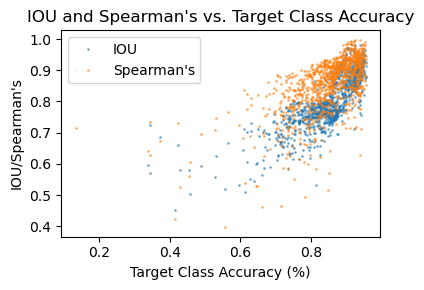

(<Figure size 400x300 with 1 Axes>,
 <AxesSubplot:title={'center':"IOU and Spearman's vs. Target Class Accuracy"}, xlabel='Target Class Accuracy (%)', ylabel="IOU/Spearman's">)

In [39]:
both_plot_save_path = os.path.join(logit_bump_save_dir, 'iou_spearman_vs_post_target_acc.png')

plot(
    xs=[xs, xs],
    ys=[ious, spearmans],
    labels=["IOU","Spearman's"],
    alpha=0.5,
    marker_size=1,
    title="IOU and Spearman's vs. Target Class Accuracy",
    xlabel='Target Class Accuracy (%)',
    ylabel="IOU/Spearman's",
    line=False,
    show=True,
    fig_size=(4,3),
    save_path=both_plot_save_path)

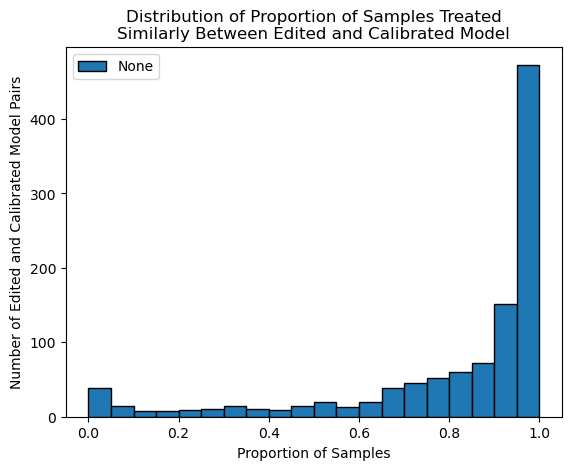

(array([ 38.,  15.,   8.,   8.,   9.,  11.,  14.,  10.,   9.,  14.,  20.,
         13.,  20.,  39.,  45.,  52.,  60.,  72., 152., 473.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

<Figure size 640x480 with 0 Axes>

In [99]:
# Create histogram from all_alpha.csv
all_csv = None
csv_template_path = os.path.join(logit_bump_dir_template, 'alpha_csv_thresh{}.csv'.format(threshold))
for class_name in class_list:
    csv = load_and_preprocess_csv(csv_template_path.format(class_name, n_select))
    if all_csv is None:
        all_csv = csv
    else:
        all_csv = all_csv.append(csv)
    # all_trials_csv_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_alpha_csv.csv')
# all_alpha_csv = load_and_preprocess_csv(all_trials_csv_path)

data = all_csv['n_similar_calibration'] / 70000

histogram(
    data=data,
    n_bins=20,
    xlabel='Proportion of Samples',
    ylabel='Number of Trials',
    title='Distribution of Proportion of Samples Treated\nSimilarly Between Edited and Calibrated Model')

<class 'list'>


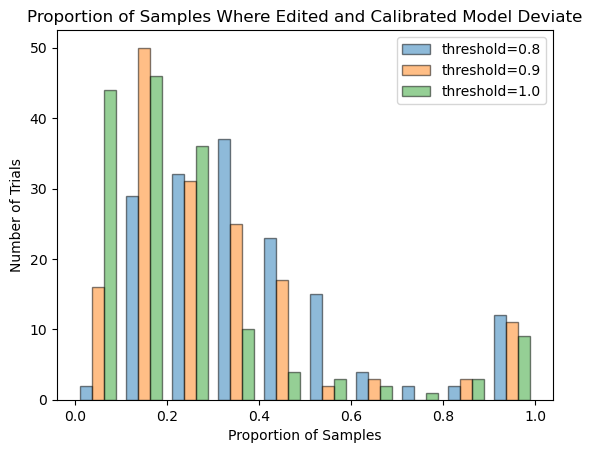

(array([[ 2., 29., 32., 37., 23., 15.,  4.,  2.,  2., 12.],
        [16., 50., 31., 25., 17.,  2.,  3.,  0.,  3., 11.],
        [44., 46., 36., 10.,  4.,  3.,  2.,  1.,  3.,  9.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

<Figure size 640x480 with 0 Axes>

In [422]:
# Create histogram from all_alpha.csv
all_csv = None
class_name = 'airplane'
csv_template_path = os.path.join(logit_bump_dir_template.format(class_name, n_select), 'alpha_csv_thresh{}.csv')
thresholds = [0.8, 0.9, 1.0]

all_data = []
labels = []
for threshold in thresholds:
    csv_path = csv_template_path.format(threshold)
    df = load_and_preprocess_csv(csv_path)
    data = df['n_rows_out_threshold'].to_numpy() / 70000
    all_data.append(data)
    labels.append('threshold={}'.format(threshold))
    # all_trials_csv_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_alpha_csv.csv')
# all_alpha_csv = load_and_preprocess_csv(all_trials_csv_path)

# data = all_csv['n_similar_calibration'] / 70000
print(type(all_data))
histogram(
    data=all_data,
    labels=labels,
    data_range=[0, 1],
    multi_method='side',
    alpha=0.5,
    n_bins=10,
    xlabel='Proportion of Samples',
    ylabel='Number of Trials',
    
    title='Proportion of Samples Where Edited and Calibrated Model Deviate')

#### Focus on top N edits from this class

In [165]:
n_trials = 20
n_trials = n_top
print(n_top)
# sorted_df = edit_trial_df.sort_values('Post Target Accuracy', ascending=False)
top_n_idxs = sorted_df['Unnamed: 0'][:n_trials].to_numpy()
print(top_n_idxs)
top_edit_trial_paths = [edit_trial_paths[idx] for idx in top_n_idxs]
top_logit_bump_trial_paths = [logit_bump_trial_paths[idx] for idx in top_n_idxs]

30
[ 63  12  52  49  72  88  21  18  93 109  11  98  46  73  62  22  69  78
   0 107  89  28  30  33  96 108 110   1  29 111]


In [166]:
idxs = [i for i in range(pre_edit_predictions.shape[0])]
all_df = pd.DataFrame({
    'idx': idxs,
    'labels': val_labels.astype(int),
    'pre_edit_predictions': pre_edit_predictions.cpu().numpy()})

# obtain rows in data frame of target class that the original model mispredicts on

print(len(all_df))

70000


In [169]:
# both_fixed_idxs = np.concatenate(both_fixed_idxs)
def get_sorted_idxs_counts(counter):
    idxs, counts = np.array(list(counter.keys())), np.array(list(counter.values()))
    sorted_idxs = np.argsort(-np.array(counts))
    idxs = idxs[sorted_idxs]
    counts = counts[sorted_idxs]
    return idxs, counts
    
print(both_fixed_idxs)
both_fixed_counter = Counter(both_fixed_idxs_flat.tolist())
both_fixed_sorted_idxs, both_fixed_counts = get_sorted_idxs_counts(both_fixed_counter)

edited_fixed_counter = Counter(edited_fixed_idxs_flat.tolist())
edited_fixed_sorted_idxs, edited_fixed_counts = get_sorted_idxs_counts(edited_fixed_counter)
print(edited_fixed_sorted_idxs[:5], edited_fixed_counts[:5])

logit_bump_fixed_counter = Counter(logit_bump_fixed_idxs_flat.tolist())
logit_bump_fixed_sorted_idxs, logit_bump_fixed_counts = get_sorted_idxs_counts(logit_bump_fixed_counter)
print(logit_bump_fixed_sorted_idxs[:5], logit_bump_fixed_counts[:5])

neither_fixed_counter = Counter(neither_fixed_idxs_flat.tolist())
neither_fixed_sorted_idxs, neither_fixed_counts = get_sorted_idxs_counts(neither_fixed_counter)
print(neither_fixed_sorted_idxs[:5], neither_fixed_counts[:5])

[array([   8,    9,   12, ..., 6993, 6995, 6997]), array([   8,    9,   14, ..., 6968, 6971, 6995]), array([   8,    9,   14,   15,   20,   36,   42,   44,   45,   46,   62,
         67,   73,   80,   95,   97,  115,  126,  129,  136,  149,  152,
        153,  157,  168,  175,  177,  181,  182,  185,  189,  209,  237,
        247,  262,  267,  271,  279,  299,  306,  311,  321,  328,  335,
        337,  343,  354,  372,  400,  408,  412,  415,  417,  443,  444,
        448,  452,  456,  457,  470,  477,  486,  491,  497,  508,  510,
        513,  523,  528,  536,  538,  545,  585,  586,  600,  603,  604,
        619,  623,  630,  655,  658,  681,  683,  687,  692,  699,  701,
        703,  711,  718,  720,  729,  731,  735,  736,  739,  745,  750,
        772,  775,  778,  788,  789,  796,  803,  811,  817,  819,  820,
        826,  835,  836,  849,  854,  862,  866,  868,  881,  882,  894,
        898,  927,  928,  937,  952,  955,  959,  970,  975, 1012, 1019,
       1022, 1025, 1027

#### Display aggregation of which images were corrected by both methods across top N edits

In [ ]:
# Get list of validation set images
val_image_paths_path = 'paths/datasets/cinic-10-imagenet/valid_images.txt'
val_image_paths = read_lists(val_image_paths_path)
n_display = 30

def display_images(image_paths,
                   select_idxs,
                   n_display,
                   items_per_row=5,
                   title=None,
                   image_titles=None):
    
    # Limit number of images to display
    if len(select_idxs) > n_display:
        select_idxs = select_idxs[:n_display]
        if image_titles is not None:
            image_titles = image_titles[:n_display]
    
    # Load all images
    images = []
    # if image_titles is not None:
    image_titles_temp = []
    for count_idx, idx in enumerate(select_idxs):
        image_path = image_paths[idx]
        images.append(load_image(image_path))
        
        if image_titles is not None:
            image_id = os.path.basename(image_path)
            image_titles_temp.append(str(image_titles[count_idx]) + '\n{}'.format(image_id))
        else:
            image_titles_temp.append(image_id)
    image_titles = image_titles_temp
        
    images = make_grid(
        flattened=images,
        items_per_row=items_per_row)
    
    if image_titles is not None and type(image_titles[0]) != list:
        image_titles = make_grid(
            flattened=image_titles,
            items_per_row=items_per_row)
    
    show_image_rows(
        images,
        figure_title=title,
        image_titles=image_titles)

# Display images both methods fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=both_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=both_fixed_counts,
    title='Images corrected by editing and calibration (n edits that corrected images)')

# Display images only editing fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=edited_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=edited_fixed_counts,
    title='Images corrected by editing only (n edits that corrected images)')
        
# Display images only calibration fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=logit_bump_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=logit_bump_fixed_counts,
    title='Images corrected by logit bumping only (n edits that corrected images)')

# Display images neither fixed
display_images(
    image_paths=val_image_paths,
    select_idxs=neither_fixed_sorted_idxs,
    n_display=n_display,
    image_titles=neither_fixed_counts,
    title='Images neither corrected (n edits that corrected images)')
    

#### Look at which images were changed for individual edits

In [ ]:
for idx in range(n_trials):
    cur_trial_path = top_edit_trial_paths[idx]
    cur_trial_path = os.path.basename(os.path.dirname(cur_trial_path))
    cur_both_fixed = np.sort(both_fixed_idxs[idx])
    cur_edit_fixed = np.sort(edited_fixed_idxs[idx])
    cur_logit_bump_fixed = np.sort(logit_bump_fixed_idxs[idx])
    cur_neither_fixed = neither_fixed_idxs[idx]
    
    print(cur_both_fixed.shape)
    print(cur_edit_fixed.shape)
    print(cur_logit_bump_fixed.shape)
    
    for mode, data in zip(['Both', 'Edit', 'Logit Bump'],[cur_both_fixed, cur_edit_fixed, cur_logit_bump_fixed]):
        if data.shape[0] == 0:
            print("No examples in {}...".format(mode))
            continue
        
        display_images(
            image_paths=val_image_paths,
            select_idxs=data,
            n_display=25,
            items_per_row=5,
            title="{} ({}) {}".format(cur_trial_path, idx, mode),
            image_titles=None)
    # if idx == 5:
    #     break